# 🧠🤖 Melhorando a Codificação do Perceptron e Avaliando em Outras Bases

## Instalação e import de pacotes

In [ ]:
!python -m pip install numpy matplotlib seaborn opencv-python Pillow scikit-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
sns.set_style('darkgrid')

## Uma Implementação mais Limpa do Perceptron 

### Funções como Argumentos de Funções

Como ilustrado abaixo, funções podem ser armazenadas em variáveis e utilizadas como entrada ou saída de funções. 

Neste caso, as variáveis são anotadas com o tipo `Callable` da biblioteca `collections.abc`.


In [ ]:
import numpy as np
from collections.abc import Callable

# versao simplificada da funcao do perceptron
def perceptron_fn(x: np.ndarray,
                weights: np.ndarray,
                bias: float,
                activation_fn: Callable): # funcao passada como argumento
    z = np.dot(weights, x) + bias
    o = activation_fn(z)  # chamada da funcao de ativacao
    return o

# funcao de ativacao
def threshold_fn(z):
    return np.where(np.asarray(z) >= 0, 1, 0)

# chamada da funcao
perceptron_fn(x=[1, 3],
              weights=[0.5, 0.2],
              bias=-1,
              activation_fn=threshold_fn)

array(1)

**Nota:** A função `threshold_fn` usa alguns truques sutis para que a funcao funcione com listas, arrays do numpy ou escalares. 

A conversão para `np.array` na primeira linha lida com o caso de uma lista ser passada como entrada. 

A chamada da função `np.where` retorna `1` quando a posição do array ou o valor escalar é maior ou igual a zero e `0`, caso contrário.


In [15]:
scalar = 5
arr = np.array([5, -2, 1, 0.5, 0])

print("Result for scalar:", threshold_fn(-1))
print("Result for list:",  threshold_fn([5, -2, 1, 0.5, 0]))
print("Result for array:",  threshold_fn(np.array([5, -2, 1, 0.5, 0])))

Result for scalar: 0
Result for list: [1 0 1 1 1]
Result for array: [1 0 1 1 1]


### Classes as Callable

Classes podem implementar o método `__call__` para que seus objetos se tornem `Callable`.  Quando o objeto é utilizado como uma função, o método `__call__` é invocado. 

Como ilustrado abaixo, uma das vantagens desta abordagem é a possibilidade de manter estado (dados) entre chamadas das funções.

In [28]:
class Soma:
    def __init__(self):
        self.n_chamadas = 0

    def __call__(self, x, y):
        self.n_chamadas += 1
        return x + y

soma = Soma()

print("soma(3, 5) = ", soma(3, 5))
print("soma(2, -1) = ", soma(2, -1))
print("soma(0, 0) = ", soma(0, 0))

print(f"A funcao soma foi invocada {soma.n_chamadas} vezes.")

soma(3, 5) =  8
soma(2, -1) =  1
soma(0, 0) =  0
A funcao soma foi invocada 3 vezes.


Objetos que possuem o método `__call__` podem ser utilizados como entrada/saída de funções da mesma forma que funções simples.

In [29]:
from collections.abc import Callable

def realiza_op(x, y, fn: Callable):
    return fn(x, y)

soma = Soma()

print("Resultado:", realiza_op(3, 5, soma))
print("Resultado:", realiza_op(2, 7, soma))
print("Resultado:", realiza_op(-1, 3, soma))

print("Numero de chamadas: ", soma.n_chamadas)


Resultado: 8
Resultado: 9
Resultado: 2
Numero de chamadas:  3


### Melhorando o Perceptron

A célula abaixo contém uma implementação melhorada do `Perceptron` vista na aula anterior. 

- A função de ativação é passada como argumento no construtor.
- A classe `CallbackInterface` define uma interface com funções de callback invocadas a cada amostra e a cada época.

Vamos usar as funções de callback para exibir informações durante o treinamento e salvar informações históricas para visualização posterior.

**Nota:** note que o valor default para o argumento `callback` no método train é um objeto do tipo `CallbackInterface`, portanto se não for passado um valor, a função de `callback` não fará nada.


In [216]:
import numpy as np

class CallbackInterface:
    """Interface for callback classes. Override the following methods to implement step and epoch callbacks."""
    def step(self, sample_idx, model, updates):
        pass

    def epoch(self, epoch_idx, model):
        pass


class Perceptron:
    def __init__(self, initial_weights: np.ndarray,
                        initial_bias: float,
                        activation_fn: Callable):
        # inicializacao de pesos e bias
        self._weights = initial_weights
        self._bias = initial_bias
        self._activation_fn = activation_fn

    def forward(self, x: np.ndarray) -> float:
        linear_output = np.sum(np.multiply(x, self._weights)) + self._bias
        output = self._activation_fn(linear_output)
        return output

    def train(self, X: np.ndarray,
                    y: np.ndarray,
                    lr: float,
                    epochs: int,
                    callback: CallbackInterface = CallbackInterface()):

        n_samples, n_features = X.shape

        for epoch_idx in range(epochs): # repeticao por um numero de epocas
            for sample_idx, x_i in enumerate(X): # iteracao pelas amostras do dataset

                # predicao da saida para a amostra x_i
                y_predicted = self.forward(x_i)

                # calculo do erro
                error = y[sample_idx] - y_predicted

                # atualizacao dos parametros
                weight_update = lr * error * x_i
                bias_update = lr * error
                self._weights = self._weights + weight_update
                self._bias = self._bias + bias_update

                callback.step(sample_idx, self, [weight_update, bias_update])

            callback.epoch(epoch_idx, self)

### A Clases com Métodos de Callback


Abaixo é definida a nossa classe de callback. Ao implementar estas classes, tome cuidado com: 
- ⚠️ cópias por referência
- ⚠️ o consumo de memória ao salvar informações durante o treinamento


In [215]:

class MyCallback(CallbackInterface):
    def __init__(self, X, y, n_epochs):
        self._X = X
        self._y = y
        self._n_epochs = n_epochs
        self._sum_updates = 0
        self.history = []

    def step(self, sample_idx, model, updates):
        #################################
        # Uncomment to see weights updates for step
        #################################
        # print(f"\tSample {sample_idx} - Weights: {model._weights} Bias: {model._bias} - Weights update {updates[0]} Bias update {updates[1]}")
        weights_updates, bias_updates = updates
        self._sum_updates += np.sum(np.abs(weights_updates))
        self._sum_updates += np.sum(np.abs(bias_updates))

    def epoch(self, epoch_idx, model):
        acc = self._print_accuracy(epoch_idx, perceptron)

        self.history.append({
            "epoch": epoch_idx,
            "weights": perceptron._weights.copy(),
            "bias": perceptron._bias.copy(),
            "sum_updates": self._sum_updates,
            "accuracy": acc
        })

        self._sum_updates = 0

    def _print_accuracy(self, epoch_idx, perceptron):
        predictions = np.array([perceptron.forward(sample) for sample in self._X])
        acc = 1 - (np.count_nonzero(np.subtract(predictions, self._y)) / len(predictions))
        print(f"Epoch: {epoch_idx} of {self._n_epochs} -  Training Accuracy: {acc: .3f}")

        #################################
        # Uncomment to compare predictions and true labels
        #################################
        # print(f"\tpredictions: {predictions}\n")
        # print(f"\ty: {self._y}\n")

        return acc

### Usando o Perceptron Após as Modificações

In [127]:
# dados de treinamento
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
])

y = np.array([
    0,
    0,
    0,
    1
])

# parametros de treinamento
n_epochs = 10
lr = 0.2

# funcao de ativacao
def threshold_fn(z):
    return np.where(np.asarray(z) >= 0, 1, 0)

# inicializacao do modelo
perceptron = Perceptron(initial_weights = np.array([0, 0]),
                        initial_bias = 0,
                        activation_fn = threshold_fn)

# inicializacao do objeto de callback
callback = MyCallback(X, y, n_epochs)
perceptron.train(X, y, lr, n_epochs, callback)

Epoch: 0 of 10 -  Training Accuracy:  0.250
Epoch: 1 of 10 -  Training Accuracy:  0.500
Epoch: 2 of 10 -  Training Accuracy:  1.000
Epoch: 3 of 10 -  Training Accuracy:  1.000
Epoch: 4 of 10 -  Training Accuracy:  1.000
Epoch: 5 of 10 -  Training Accuracy:  1.000
Epoch: 6 of 10 -  Training Accuracy:  1.000
Epoch: 7 of 10 -  Training Accuracy:  1.000
Epoch: 8 of 10 -  Training Accuracy:  1.000
Epoch: 9 of 10 -  Training Accuracy:  1.000


### Visualização da Evolução do Treinamento 

Na célula abaixo, note como usamos os dados armazenados em `callback.history` para plotar os gráficos. 

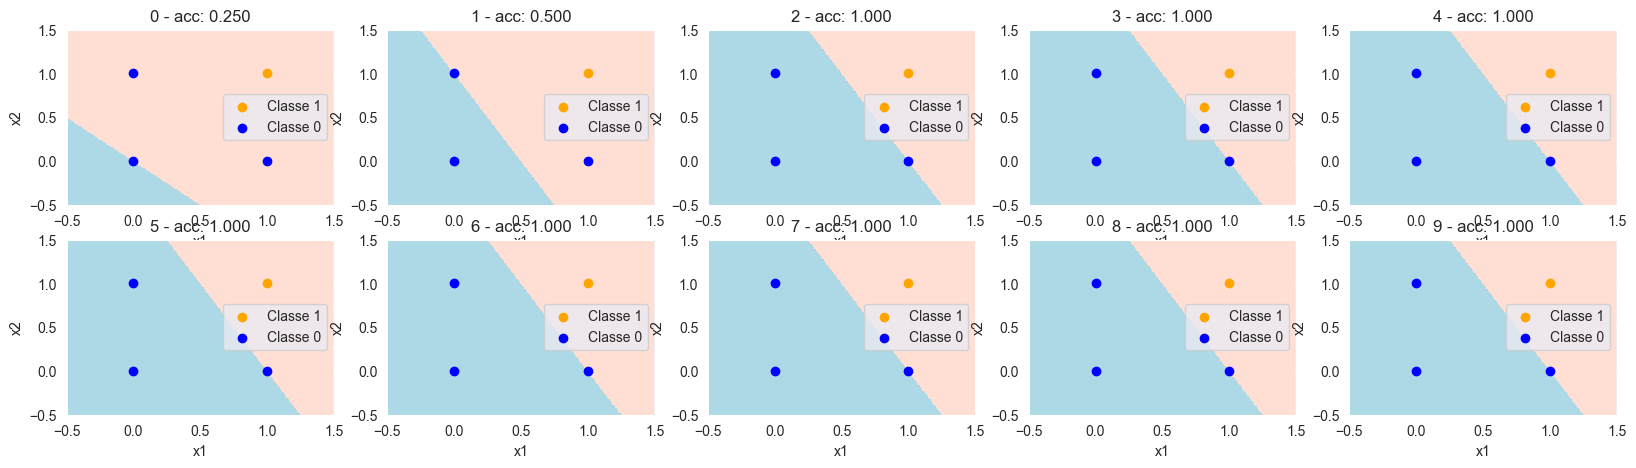

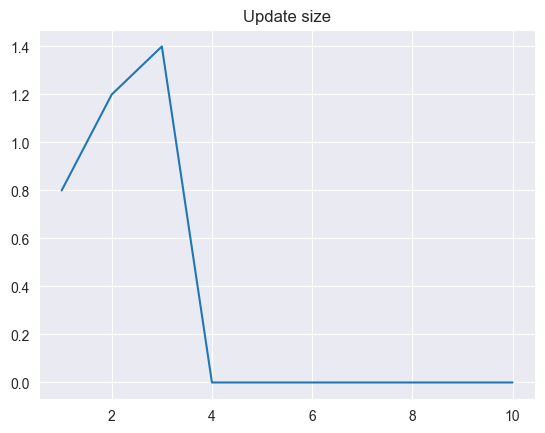

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def draw_classification_region(X, y, perceptron):
    cmap_light = ListedColormap(['#ADD8E6', '#AAFFAA', '#ffdfd4'])

    h = .01

    x_min = X[:, 0].min() - 0.5
    x_max = X[:, 0].max() + 0.5
    y_min = X[:, 1].min() - 0.5
    y_max = X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = np.array([perceptron.forward([x1, x2])
                 for x1, x2 in zip(xx.ravel(), yy.ravel())])
    Z = Z.reshape(xx.shape)

    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='orange', label='Classe 1')
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', label='Classe 0')

    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.xlim((x_min, x_max))
    plt.ylim((y_min, y_max))
    plt.legend(loc='best')


plt.figure(figsize=(20, 5))

for idx, epoch_data in enumerate(callback.history):
    perceptron._weights = epoch_data["weights"]
    perceptron._bias = epoch_data["bias"]
    predictions = np.array([perceptron.forward(x) for x in X])
    accuracy = np.mean(predictions == y)
    plt.subplot(2, 5, idx + 1)
    plt.title(f"{idx} - acc: {accuracy:.3f}")
    draw_classification_region(X, y, perceptron)

plt.figure()
plt.title("Update size")
epochs_ids = np.array(range(len(callback.history))) + 1
update_size = [np.sum(e["sum_updates"]) for e in callback.history]
plt.plot(epochs_ids, update_size)
plt.show()

## Analisando o Perceptron em Outros Datasets

Nesta seção, vamos avaliar como o perceptron se comporta com bases de dados que não são obviamente linearmente separáveis.

### Moons

In [128]:
from sklearn.datasets import make_moons

# cria o dataset
X, y = make_moons(noise=0.3, random_state=0)

# inicializacao do modelo
perceptron = Perceptron(initial_weights=np.array([0, 0]),
                        initial_bias=0,
                        activation_fn=threshold_fn,
                        )

callback = MyCallback(X, y, n_epochs=15)
perceptron.train(X, y, lr=0.2, epochs=15, callback=callback)

Epoch: 0 of 15 -  Training Accuracy:  0.770
Epoch: 1 of 15 -  Training Accuracy:  0.750
Epoch: 2 of 15 -  Training Accuracy:  0.780
Epoch: 3 of 15 -  Training Accuracy:  0.780
Epoch: 4 of 15 -  Training Accuracy:  0.790
Epoch: 5 of 15 -  Training Accuracy:  0.780
Epoch: 6 of 15 -  Training Accuracy:  0.800
Epoch: 7 of 15 -  Training Accuracy:  0.790
Epoch: 8 of 15 -  Training Accuracy:  0.800
Epoch: 9 of 15 -  Training Accuracy:  0.790
Epoch: 10 of 15 -  Training Accuracy:  0.800
Epoch: 11 of 15 -  Training Accuracy:  0.800
Epoch: 12 of 15 -  Training Accuracy:  0.750
Epoch: 13 of 15 -  Training Accuracy:  0.770
Epoch: 14 of 15 -  Training Accuracy:  0.800


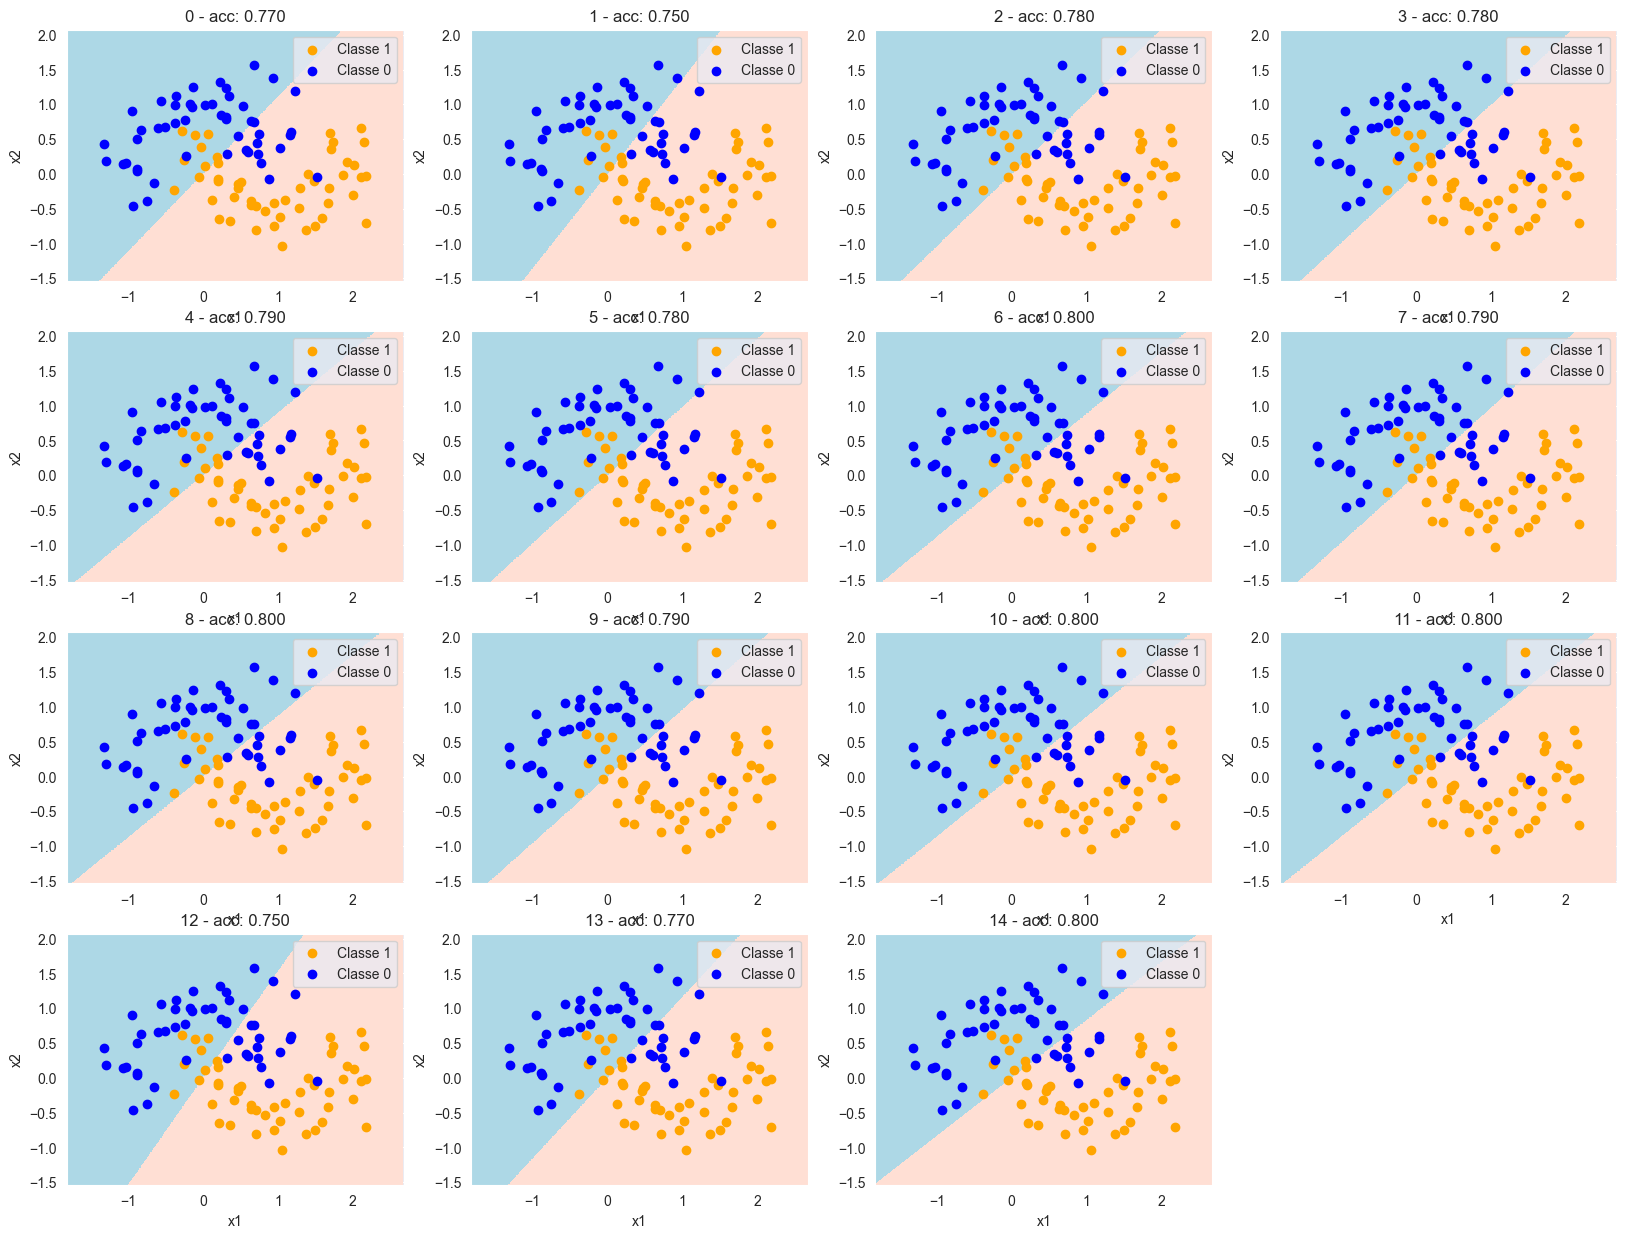

In [ ]:
plt.figure(figsize=(20, 15))

for idx, epoch_data in enumerate(callback.history):
    perceptron._weights = epoch_data["weights"]
    perceptron._bias = epoch_data["bias"]
    accuracy = epoch_data["accuracy"]
    plt.subplot(4, 4, idx + 1)
    plt.title(f"{idx} - acc: {accuracy:.3f}")
    draw_classification_region(X, y, perceptron)

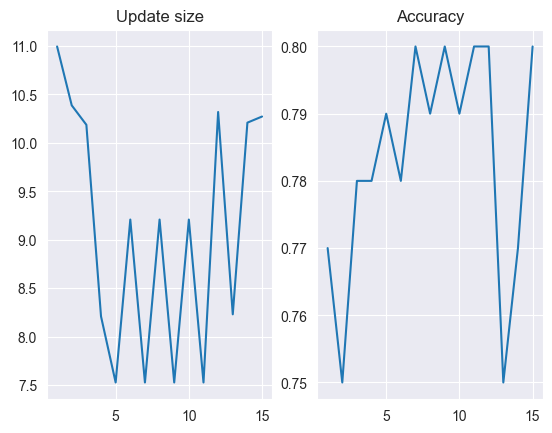

In [130]:
plt.subplot(1, 2, 1)
plt.title("Update size")
epochs_ids = np.array(range(len(callback.history))) + 1
update_size = [e["sum_updates"] for e in callback.history]
plt.plot(epochs_ids, update_size)
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(epochs_ids, [e["accuracy"] for e in callback.history])
plt.show()

### Circles

In [136]:
from sklearn.datasets import make_circles

# cria o dataset
X, y = make_circles(noise=0.2, factor=0.5, random_state=1)

# inicializacao do modelo
perceptron = Perceptron(initial_weights=np.array([0, 0]),
                        initial_bias=0,
                        activation_fn=threshold_fn)

callback = MyCallback(X, y, n_epochs=20)
perceptron.train(X, y, lr=1, epochs=20, callback=callback)

Epoch: 0 of 20 -  Training Accuracy:  0.450
Epoch: 1 of 20 -  Training Accuracy:  0.420
Epoch: 2 of 20 -  Training Accuracy:  0.400
Epoch: 3 of 20 -  Training Accuracy:  0.490
Epoch: 4 of 20 -  Training Accuracy:  0.480
Epoch: 5 of 20 -  Training Accuracy:  0.400
Epoch: 6 of 20 -  Training Accuracy:  0.480
Epoch: 7 of 20 -  Training Accuracy:  0.400
Epoch: 8 of 20 -  Training Accuracy:  0.390
Epoch: 9 of 20 -  Training Accuracy:  0.530
Epoch: 10 of 20 -  Training Accuracy:  0.490
Epoch: 11 of 20 -  Training Accuracy:  0.380
Epoch: 12 of 20 -  Training Accuracy:  0.500
Epoch: 13 of 20 -  Training Accuracy:  0.400
Epoch: 14 of 20 -  Training Accuracy:  0.390
Epoch: 15 of 20 -  Training Accuracy:  0.500
Epoch: 16 of 20 -  Training Accuracy:  0.470
Epoch: 17 of 20 -  Training Accuracy:  0.380
Epoch: 18 of 20 -  Training Accuracy:  0.490
Epoch: 19 of 20 -  Training Accuracy:  0.390


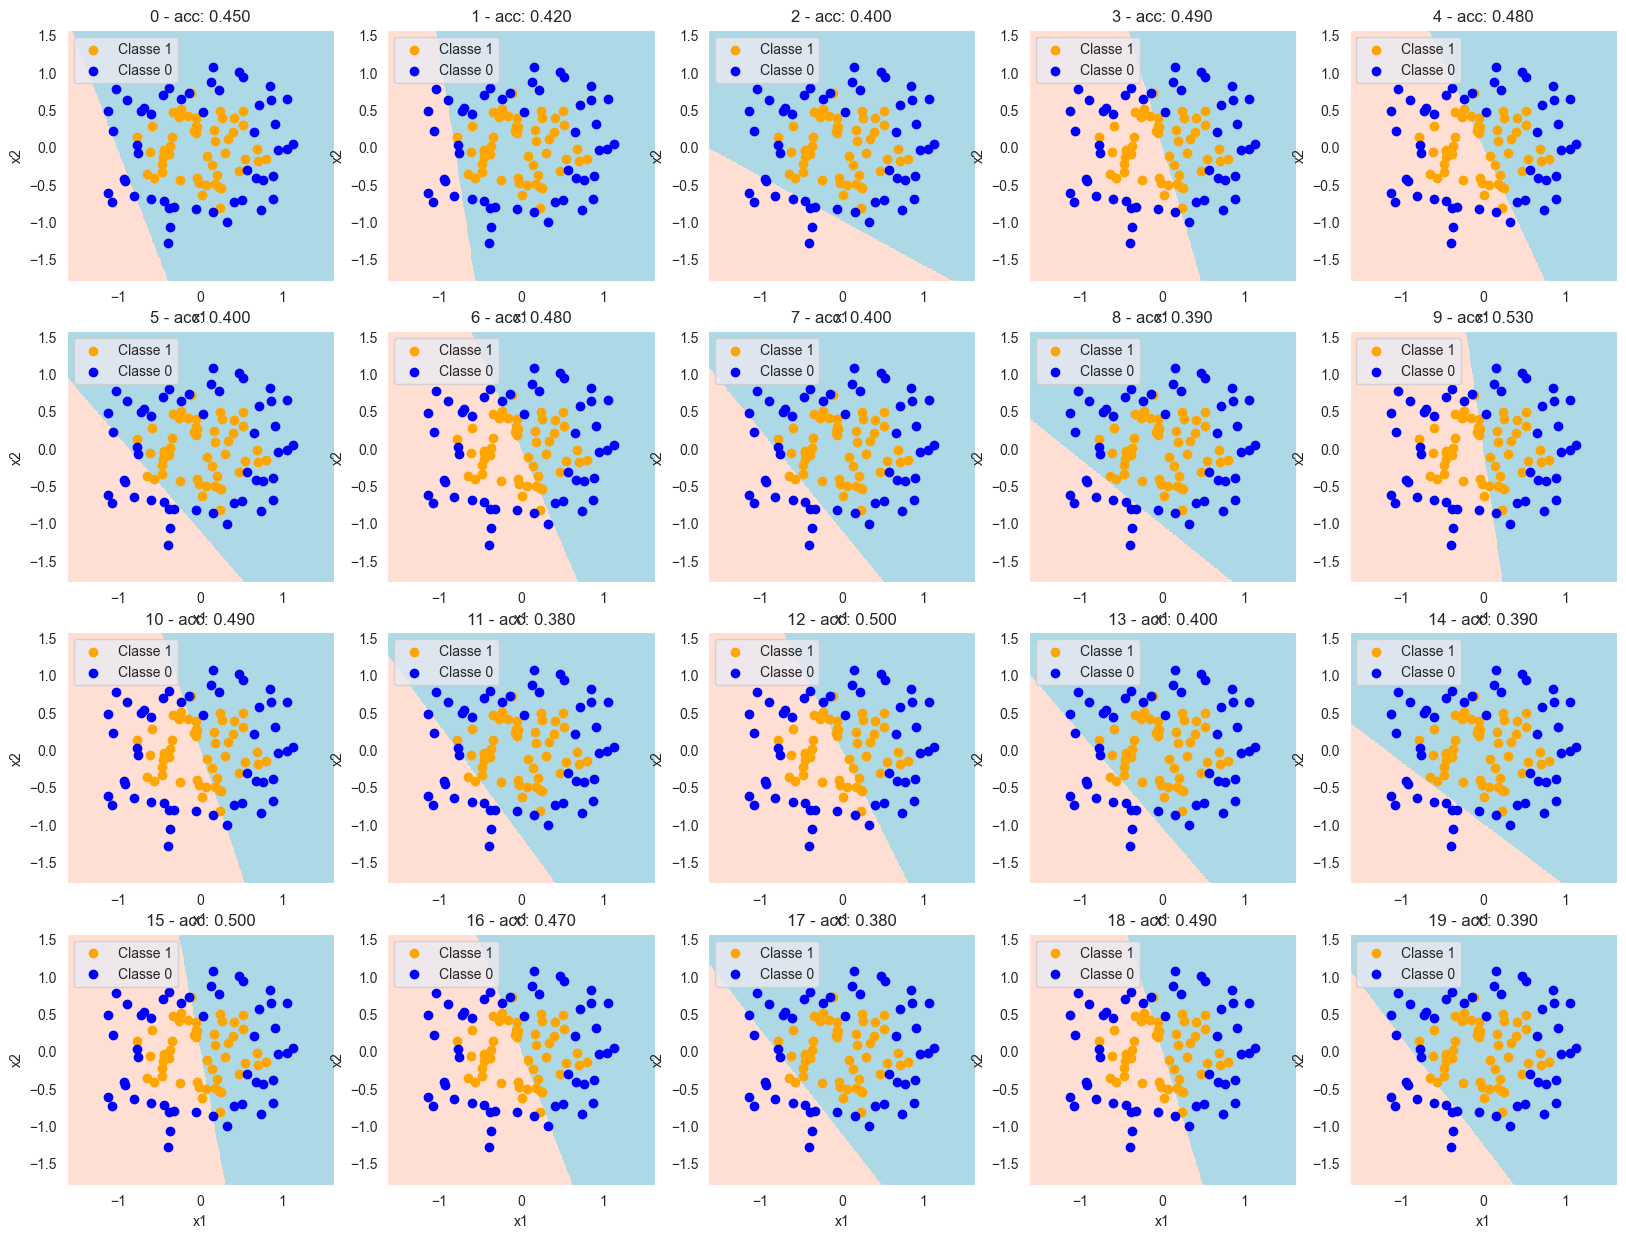

In [137]:
plt.figure(figsize=(20, 15))

for idx, epoch_data in enumerate(callback.history):
    perceptron._weights = epoch_data["weights"]
    perceptron._bias = epoch_data["bias"]
    accuracy = epoch_data["accuracy"]
    plt.subplot(4, 5, idx + 1)
    plt.title(f"{idx} - acc: {accuracy:.3f}")
    draw_classification_region(X, y, perceptron)

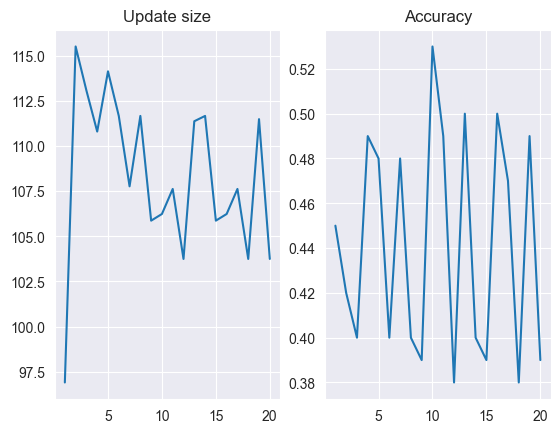

In [145]:
plt.subplot(1, 2, 1)
plt.title("Update size")
epochs_ids = np.array(range(len(callback.history))) + 1
update_size = [e["sum_updates"] for e in callback.history]
plt.plot(epochs_ids, update_size)
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(epochs_ids, [e["accuracy"] for e in callback.history])
plt.show()

### Imagens de Digitos Manuscritos

O código abaixo mostra como fazer download da base de dados MNIST contendo digitos manuscritos. 

Selecione um conjunto aleatorio de 30 imagens de números 0 e 30 imagens de números 7.

Treine e avalie a performance do perceptron na classificação usando 20 imagens de cada grupo. 

Em seguida, plote as 10 imagens restantes de cada grupo com a classe predita e esperada.

In [139]:
import matplotlib.pyplot
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, cache=False)
mnist_X = mnist.data.astype('float32')
mnist_y = mnist.target.astype('int64')
mnist_X /= 255.0

print("x shape:", mnist_X.shape, "y shape:", mnist_y.shape)

x shape: (70000, 784) y shape: (70000,)


In [150]:
mnist_X[0].shape

(784,)

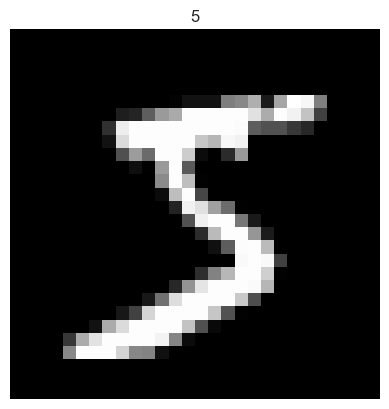

In [148]:
img = mnist_X[0].reshape((28, 28))
label = mnist_y[0]

plt.imshow(img, cmap='gray')
plt.title(str(label))
plt.axis('off')
plt.show()

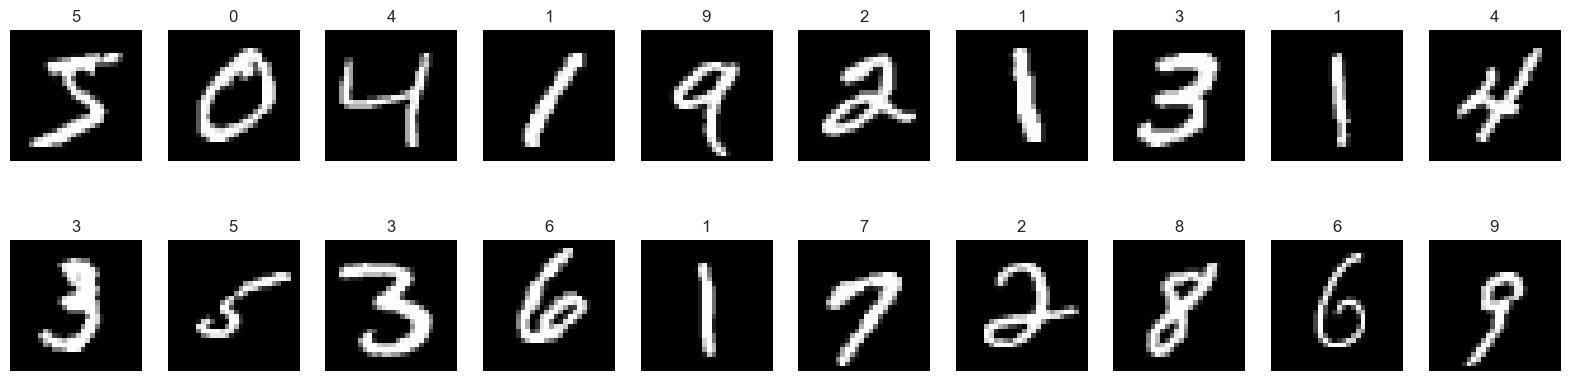

In [144]:

plt.figure(figsize=(20, 5))
for idx in range(20):
    plt.subplot(2, 10, idx+1)
    img = mnist_X[idx].reshape((28, 28))
    plt.imshow(img, cmap='gray')
    plt.title(str(mnist_y[idx]))
    plt.axis('off')

plt.show()

In [ ]:
seven_imgs = mnist_X[mnist_y == 7]
zero_imgs = mnist_X[mnist_y == 0]

print("sevens:", seven_imgs.shape, "zeros:", zero_imgs.shape)

sevens: (7293, 784) zeros: (6903, 784)


In [185]:

X = np.concatenate([zero_imgs[:40], seven_imgs[:40]], axis=0)
y = np.array([0] * 40 + [1] * 40)  # zeros are 0 and sevens are 1

print(X.shape, y.shape)

(80, 784) (80,)


In [186]:

perceptron = Perceptron(initial_weights=np.array([0] * 784),
                        initial_bias=0,
                        activation_fn=threshold_fn)

callback = MyCallback(X, y, n_epochs=20)
perceptron.train(X, y, lr=0.2, epochs=20, callback=callback)

Epoch: 0 of 20 -  Training Accuracy:  0.588
Epoch: 1 of 20 -  Training Accuracy:  0.738
Epoch: 2 of 20 -  Training Accuracy:  0.963
Epoch: 3 of 20 -  Training Accuracy:  0.988
Epoch: 4 of 20 -  Training Accuracy:  1.000
Epoch: 5 of 20 -  Training Accuracy:  1.000
Epoch: 6 of 20 -  Training Accuracy:  1.000
Epoch: 7 of 20 -  Training Accuracy:  1.000
Epoch: 8 of 20 -  Training Accuracy:  1.000
Epoch: 9 of 20 -  Training Accuracy:  1.000
Epoch: 10 of 20 -  Training Accuracy:  1.000
Epoch: 11 of 20 -  Training Accuracy:  1.000
Epoch: 12 of 20 -  Training Accuracy:  1.000
Epoch: 13 of 20 -  Training Accuracy:  1.000
Epoch: 14 of 20 -  Training Accuracy:  1.000
Epoch: 15 of 20 -  Training Accuracy:  1.000
Epoch: 16 of 20 -  Training Accuracy:  1.000
Epoch: 17 of 20 -  Training Accuracy:  1.000
Epoch: 18 of 20 -  Training Accuracy:  1.000
Epoch: 19 of 20 -  Training Accuracy:  1.000


In [ ]:

test_X = np.concatenate([zero_imgs[40:60], seven_imgs[40:60]], axis=0)
test_y = np.array([0] * 20 + [1] * 20)

predictions = [perceptron.forward(img) for img in test_X]

n_errors = np.count_nonzero(np.subtract(predictions, test_y))
acc = 1 - (n_errors / len(predictions))

print(f"accuracy: {acc: .3f} - n_errors: {n_errors}")

accuracy:  0.975 - n_errors: 1


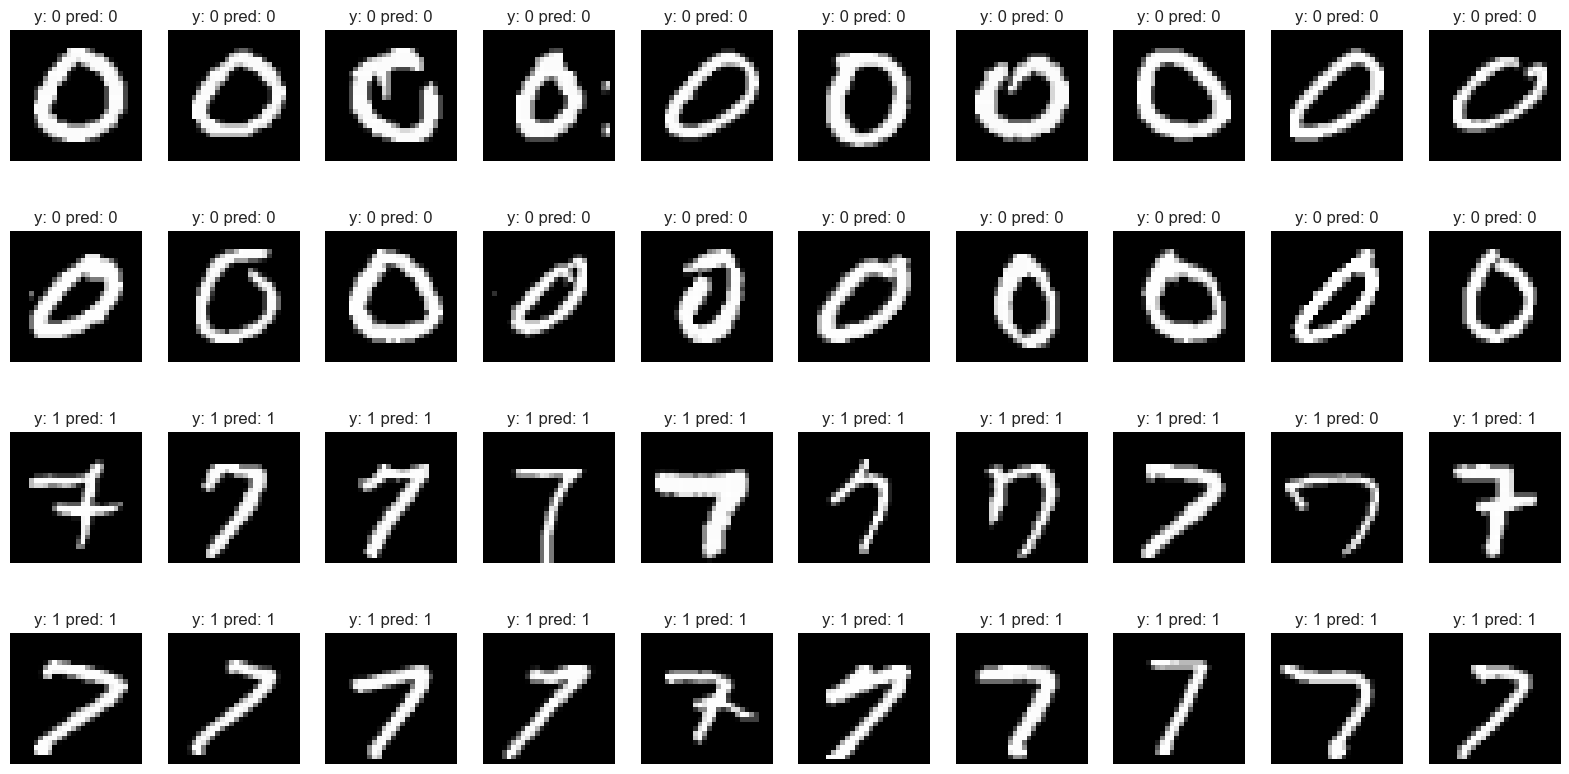

In [165]:
plt.figure(figsize=(20, 10))
for idx in range(40):
    plt.subplot(4, 10, idx+1)

    img = test_X[idx].reshape((28, 28))
    plt.imshow(img, cmap='gray')

    title = f"y: {test_y[idx]} pred: {predictions[idx]}"
    plt.title(title)

    plt.axis('off')

plt.show()

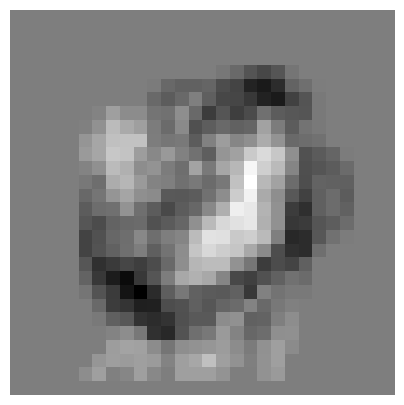

In [187]:
weights_img = perceptron._weights.reshape((28, 28))

plt.figure(figsize=(5, 5))
plt.imshow(weights_img, cmap='gray')
plt.axis('off')
plt.show()

## Atividade (Não Entregável): Diferenciando 9s e 4s 

Nesta atividade, você deve reproduzir o exemplo acima, mas usando o perceptron para diferenciar 9s e 4s.

Esta tarefa é um pouco mais desafiadora que a anterior dado que os números são mais parecidos. 

Será que o nosso modelo será capaz de diferenciar os números bem?

### Preparação do Dataset 

Separe as imagens que possuem 9s e 4s em duas listas. 

Em seguida, construa as entradas e saídas do conjunto de treinamento: 
- As entradas serão a concatenação de 40 imagens dos conjuntos acima. 
- Vamos acordar que 9 será a classe 0 e 4 será a classe 1.
- Construa o array de saída como uma concatenação de 40 números 0 seguidos de 40 números 4.

Mostre algumas imagens e os labels para verificar se estão corretos. 

In [ ]:
...  # TODO

(80, 784) (80,)


### Treinamento 

Crie uma variável do tipo perceptron e faça o treinamento usando o dataset definido na célula anterior. 

Depois de quantas épocas ele foi capaz de aprender o conjunto de treinamento? Como este valor se compara com o caso anterior?


In [ ]:
...  # TODO

### Avaliação no Conjunto de Teste

Crie um conjunto de teste usando 20 imagens de 9s e 20 imagens de 4s diferentes daquelas usadas no treinamento. 

Mostre o número de erros e a acurácia. 

In [ ]:
...  # TODO

### Visualização de Resultados 

Usando o código anterior como exemplo, visualize as amostras de teste com as classes verdadeira e predita.


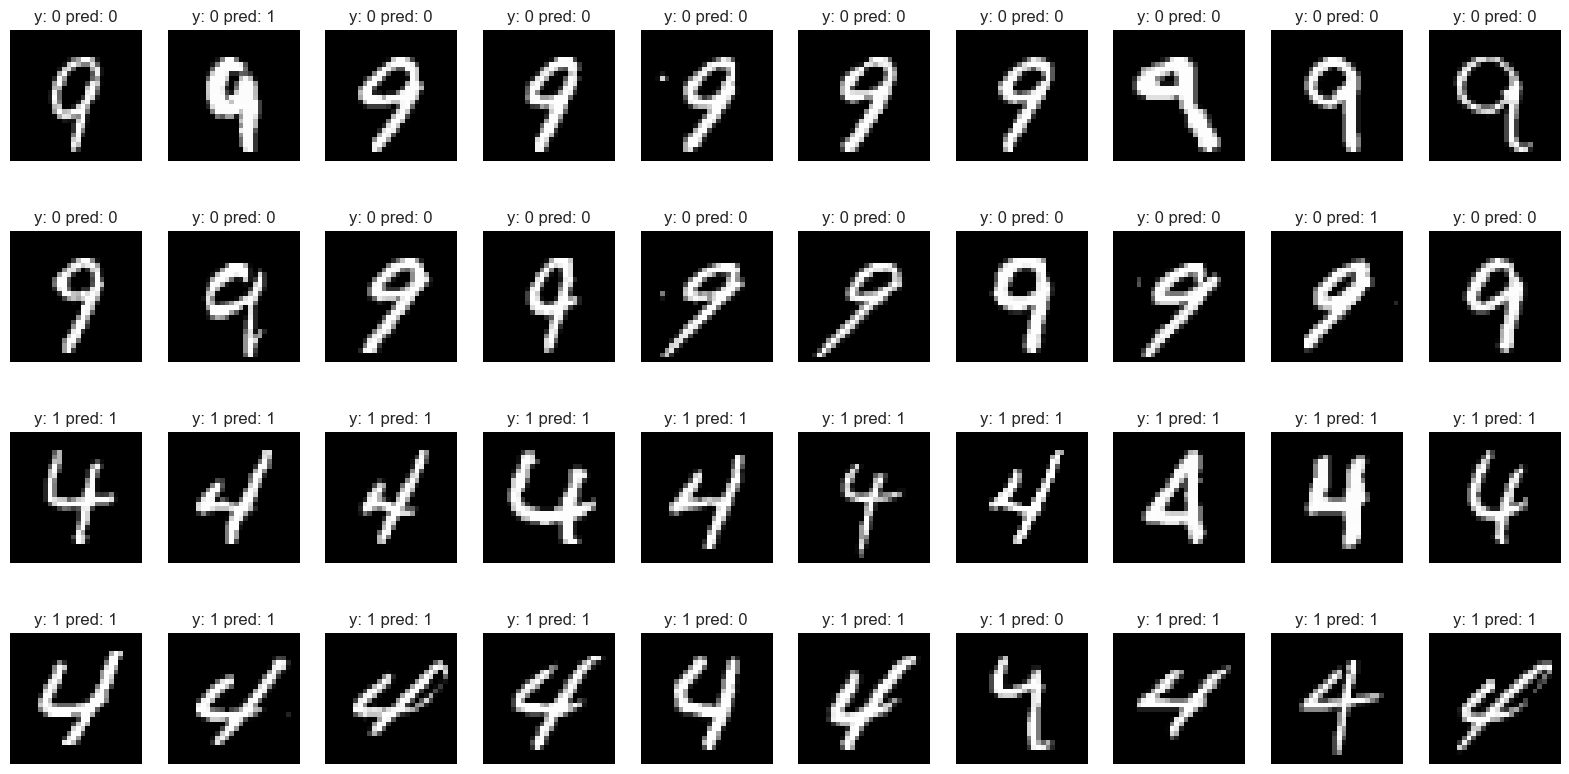

In [ ]:
...  # TODO

### Visualização dos Pesos 

Exiba o vetor de pesos como uma imagem. A imagem permite ter insights como no caso anterior? 

In [ ]:
...  # TODO